In [1]:
import torch
import pandas as pd
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from data_treatment import CreditCardDataSet
from discriminator import *
from generator import *
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import glob

In [2]:
# Noise
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): 
        return n.cuda() 
    return n

In [4]:
files_dropdown = widgets.Dropdown(
    options=glob.glob("*.csv"),
    description='File:',
    value = 'diabetes.csv',
    disabled=False,
)
display(files_dropdown)

Dropdown(description='File:', index=2, options=('creditcard.csv', 'data.csv', 'diabetes.csv'), value='diabetes…

In [18]:
file_name=files_dropdown.value
if file_name == "data.csv":
    message = "Breast Cancer Wisconsin (Diagnostic) Data Set"
    class_name = "diagnosis"
    values_names = {0: "Benign", 1: "Malignant"}
    class_len = 33
elif file_name == "creditcard.csv":
    message = "Credit Card Fraud Detection"
    class_name = "Class"
    values_names = {0: "No Frauds", 1: "Frauds"}
    class_len = 31
elif file_name == "diabetes.csv":
    message="Pima Indians Diabetes Database"
    class_name = "Outcome"
    values_names = {0: "Normal", 1: "Diabets"}
    class_len = 9
else:
     exit()

In [19]:
def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

In [20]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [21]:
lr = 0.0002
#lr= 0.0002
d_steps = 1
batch_size = 5
num_epochs = 1000
print_interval = 50
num_test_samples = 16
loss = nn.BCELoss()

In [22]:
discriminator = DiscriminatorNet(class_len)
generator = GeneratorNet(class_len)
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = optim.Adam(generator.parameters(), lr=lr)
d_error_plt = [0]
g_error_plt = [0]

In [23]:

test_noise = noise(num_test_samples)
database = CreditCardDataSet (csv_file=file_name, root_dir=".")

data_loader = torch.utils.data.DataLoader(database, batch_size=batch_size, shuffle=True)

num_batches = len(data_loader)

In [51]:
for epoch in range(num_epochs):
    print("Epoch ", epoch)

    for n_batch, real_batch in enumerate(data_loader):
        # 1. Train Discriminator
        real_data = Variable(real_batch).float()
        if torch.cuda.is_available(): 
            real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)

        # Display Progress

        if (n_batch) % print_interval == 0:
            filename = "results/" + file_name[:-4] + "/" + str(epoch) + "_" + str(n_batch) + ".txt"
            print(filename)
            file = open(filename, "w")
            flt_d_error = d_error.detach().numpy()
            flt_g_error = g_error.detach().numpy()
            print("Discriminator error: ", flt_d_error)
            print("Generator error: ", flt_g_error)
            print("")

            file.write("Discriminator error: " + str(flt_d_error) + "\n")
            file.write("Generator error: " + str(flt_g_error) + "\n")
            file.write("Points: " + str(fake_data) + "\n\n\n")
            
            d_error_plt.append(flt_d_error)
            g_error_plt.append(flt_g_error)
        #     #display.clear_output(True)
        #     # Display Images
        #     test_images = generator(test_noise).data.cpu()
        #     logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
        #     # Display status Logs
        #     #logger.display_status(epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake)
        # # Model Checkpoints


Epoch  0
results/diabetes/0_0.txt
Discriminator error:  0.45570815
Generator error:  1.4300284

results/diabetes/0_50.txt
Discriminator error:  0.3885062
Generator error:  1.2050462

results/diabetes/0_100.txt
Discriminator error:  0.35103086
Generator error:  2.4484107

results/diabetes/0_150.txt
Discriminator error:  0.8663388
Generator error:  3.4710088

Epoch  1
results/diabetes/1_0.txt
Discriminator error:  0.4159823
Generator error:  1.0377913

results/diabetes/1_50.txt
Discriminator error:  2.3258708
Generator error:  1.1267747

results/diabetes/1_100.txt
Discriminator error:  0.26420075
Generator error:  1.8426418

results/diabetes/1_150.txt
Discriminator error:  1.1931261
Generator error:  0.4122057

Epoch  2
results/diabetes/2_0.txt
Discriminator error:  1.1724294
Generator error:  1.958834



KeyboardInterrupt: 

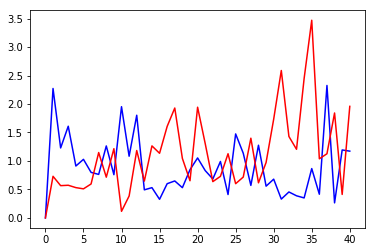

In [54]:
plt.plot(d_error_plt, 'b')
plt.plot(g_error_plt, 'r')
filename = "results/" + file_name[:-4] + "/" + "error_growth.txt"
file = open(filename, "w")
file.write("Discriminator error: " + str(d_error_plt) + "\n")
file.write("\n\n\n")
file.write("Generator error: " + str(g_error_plt) + "\n")
file.close()
plt.show()